box (3, 5)
circle (3, 4)


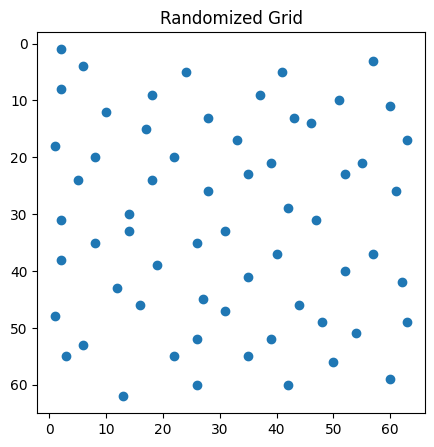

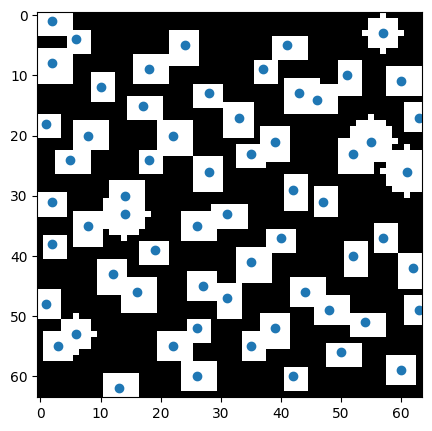

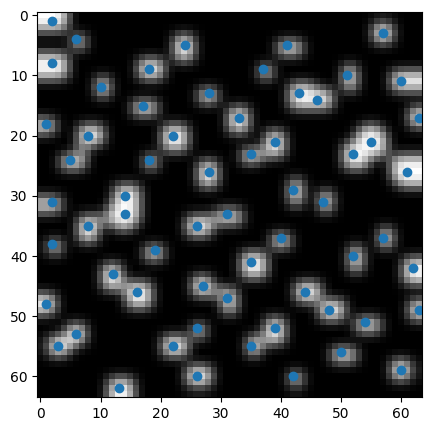

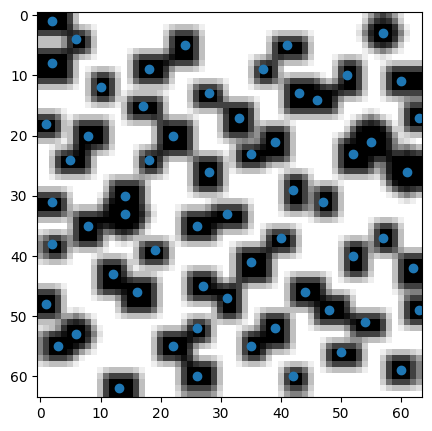

In [30]:
height = width = 64
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys

def generate_offset_grid_points(x_interval, x_range, y_interval, y_range, random_range):
    x_points = np.arange(x_range[0], x_range[1] + x_interval, x_interval)
    y_points = np.arange(y_range[0], y_range[1] + y_interval, y_interval)

    grid_points = np.array(np.meshgrid(x_points, y_points), dtype = np.float64).T.reshape(-1, 2)
    
    # 对每隔一行的 x 坐标进行偏移
    grid_points[:, 0] += (grid_points[:, 1] // y_interval % 2) * (x_interval / 2)
    grid_points[:, 1] += (grid_points[:, 0] // x_interval % 2) * (y_interval / 2)
    
    
    low, high = -random_range, random_range
    grid_points[:, 0] += np.random.uniform(low, high, size=grid_points[:, 0].shape)
    grid_points[:, 1] += np.random.uniform(low, high, size=grid_points[:, 1].shape)
    
    return grid_points

def draw_metaballs(image, points, radius, concentrate=2):
    height, width = image.shape[0:2]
    
    # 计算每个像素点的亮度值
    for x in range(width):
        for y in range(height):
            # 计算每个像素到所有点的距离
            distances = np.sqrt(np.sum(np.abs(points.astype(float) - [y, x])**2, axis=1))
            # 根据 metaball 的公式计算亮度值
            
            distances = distances**concentrate
            
            intensity = np.sum(radius/np.clip(distances, sys.float_info.epsilon, None))

            intensity = min(intensity, 1)

            # 将亮度值赋值给对应位置的像素
            image[y, x] = intensity
            
    return image
	
import random
import cv2

# 设置参数
x_interval = 8
y_interval = 8
x_range = (0, height)
y_range = (0, width)
scale = 1.3
random_range = 2

safe_area_shapes = ["box", "circle"]
safe_area_probabilities = [0.9, 0.1]

box_area_len_range = (2, 4)
circle_area_rad_range = (2, 3)

box_area_len_range = (int(np.round(box_area_len_range[0]*scale)), int(np.round(box_area_len_range[1]*scale)))
circle_area_rad_range = (int(np.round(circle_area_rad_range[0]*scale)), int(np.round(circle_area_rad_range[1]*scale)))

print("box", box_area_len_range)
print("circle", circle_area_rad_range)

# 生成带偏移的网格线交点坐标
safe_area_points = generate_offset_grid_points(x_interval, x_range, y_interval, y_range, random_range)
safe_area_points = np.round(safe_area_points[:,::-1]).astype(int)

safe_area_points = [point for point in safe_area_points if 0 <= point[0] < height and 0 <= point[1] < width]
safe_area_points = np.array(safe_area_points)

# 显示带偏移的网格线交点
fig, ax = plt.subplots(figsize=(5, 5))
ax.invert_yaxis()
plt.title('Randomized Grid')
ax.scatter(safe_area_points[:, 1], safe_area_points[:, 0])
ax.set_aspect('equal')
plt.show()

safe_danger_map = np.zeros((height, width), dtype=np.uint8)

for point in safe_area_points:
    selected_area_shape = np.random.choice(safe_area_shapes, p=safe_area_probabilities)
    
    if selected_area_shape == "box":        
        box_width = random.randint(box_area_len_range[0], box_area_len_range[1])
        box_height = random.randint(box_area_len_range[0], box_area_len_range[1])
        
        box_width_half = int(box_width/2)
        box_height_half = int(box_height/2)
        
        box_min = ((point[1]-box_width_half), (point[0]-box_height_half))
        box_max = ((point[1]+box_width-box_width_half), (point[0]+box_height-box_height_half))
        
        cv2.rectangle(safe_danger_map, box_min, box_max, 255, -1)

    elif selected_area_shape == "circle":
        rad = random.randint(circle_area_rad_range[0], circle_area_rad_range[1])
        
        cv2.circle(safe_danger_map, (point[1], point[0]), rad, 255, -1)

safe_danger_map = safe_danger_map.astype(float)/255

safe_danger_map_concentrate = np.copy(safe_danger_map)
safe_danger_map_concentrate = (safe_danger_map_concentrate*255).astype(np.uint8)
kernel = np.ones((3, 3), np.uint8)
safe_danger_map_concentrate = cv2.erode(safe_danger_map_concentrate, kernel, iterations=1)
safe_danger_map_concentrate = cv2.GaussianBlur(safe_danger_map_concentrate, (5, 5), 0)
safe_danger_map_concentrate = safe_danger_map_concentrate.astype(float)/255


safe_danger_map_blur = np.copy(safe_danger_map)
safe_danger_map_blur = (safe_danger_map_blur*255).astype(np.uint8)
safe_danger_map_blur = cv2.GaussianBlur(safe_danger_map_blur, (3, 3), 0)
safe_danger_map_blur = safe_danger_map_blur.astype(float)/255


# 显示生成的 metaball 图像
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(safe_danger_map, cmap='gray', vmin=0, vmax=1)
ax.scatter(safe_area_points[:, 1], safe_area_points[:, 0])
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(safe_danger_map_concentrate, cmap='gray', vmin=0, vmax=1)
ax.scatter(safe_area_points[:, 1], safe_area_points[:, 0])
plt.show()

safe_danger_map_blur_invert = 1-safe_danger_map_blur

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(safe_danger_map_blur_invert, cmap='gray', vmin=0, vmax=1)
ax.scatter(safe_area_points[:, 1], safe_area_points[:, 0])
plt.show()

In [31]:
def find_edges_and_change(set_matrix):
    matrix = np.copy(set_matrix)
    n = len(matrix)
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    def is_edge(x, y):
        # 如果当前元素是0，则检查其是否接触到边界或者旁边有非0元素
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if nx < 0 or nx >= n or ny < 0 or ny >= n or matrix[nx][ny] > 10:
                return True
        return False

    # 遍历数组，寻找边缘
    for i in range(n):
        for j in range(n):
            if matrix[i][j] == 0 and is_edge(i, j):
                matrix[i][j] = 10

    return matrix

<Axes: >

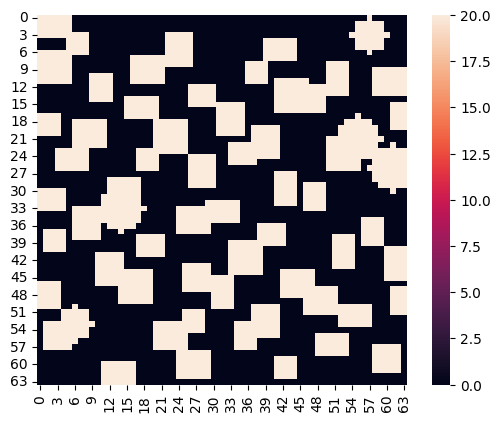

In [32]:
safe_danger_map = np.array(safe_danger_map)
N = len(safe_danger_map)
range_max = 20
for i in range(N):
    for j in range(N):
        if safe_danger_map[i, j] > 0:
            safe_danger_map[i, j] = range_max

sns.heatmap(safe_danger_map, square=True, vmin=0, vmax=range_max)


array([ 0., 20.])

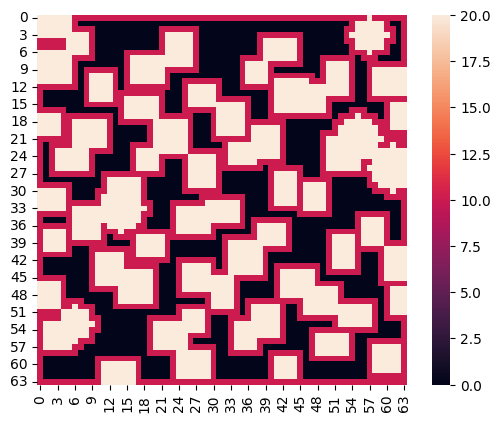

In [33]:

# 直接调用函数
changed_matrix = find_edges_and_change(safe_danger_map)
sns.heatmap(changed_matrix, square=True, vmin=0, vmax=range_max)
np.unique(safe_danger_map)

<Axes: >

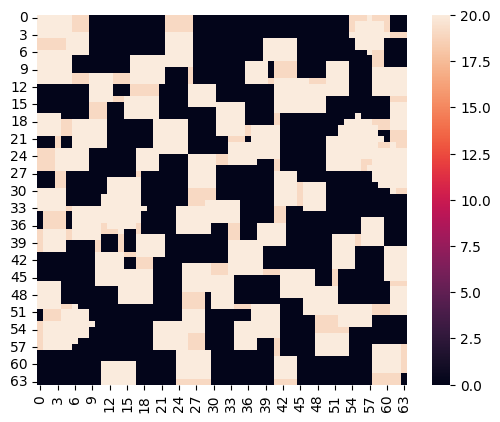

In [34]:
def update_matrix(old_matrix, num):
    matrix = np.copy(old_matrix)
    N = len(matrix)
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # 右, 左, 下, 上
    # directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    
    # 检查并收集从(x, y)开始，沿一个方向dir移动的坐标，直到边界或遇到>0
    def check_and_collect(x, y, dx, dy):
        steps = 0
        path = []
        x += dx
        y += dy
        while 0 <= x < N and 0 <= y < N and matrix[x][y] == 0 and steps <= 2:
            path.append((x, y))
            x += dx
            y += dy
            steps += 1
        if (0 <= x < N and 0 <= y < N and matrix[x][y] > 0) or x < 0 or x >= N or y < 0 or y >= N:
            return path
        return []
    
    # 需要更新的坐标集合，使用集合避免重复
    to_update = set()
    
    # 遍历矩阵的每个点
    for i in range(N):
        for j in range(N):
            if matrix[i][j] > 0:  # 对于每个为0的点
                for dx, dy in directions:  # 检查四个方向
                    path = check_and_collect(i, j, dx, dy)
                    to_update.update(path)
    
    # 更新矩阵
    for x, y in to_update:
        matrix[x][y] = num
    
    return matrix
oldmatrix = safe_danger_map
newmatrix = update_matrix(oldmatrix, range_max-1)
sns.heatmap(newmatrix, square=True, vmin=0, vmax=range_max)

17


<Axes: >

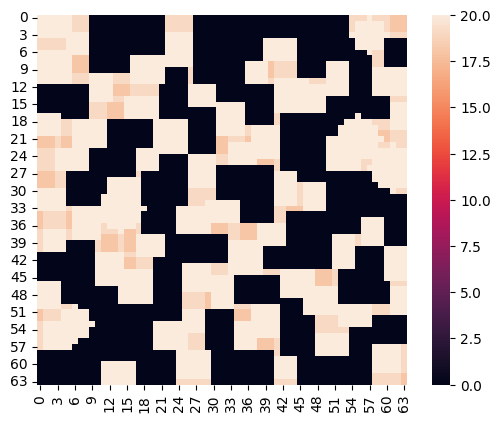

In [35]:
n = range_max - 2
while (not np.array_equal(oldmatrix, newmatrix)) and n < range_max:
    oldmatrix = newmatrix
    newmatrix = update_matrix(newmatrix, n)
    n = n-1
print(n+1)
sns.heatmap(newmatrix, square=True, vmin=0, vmax=range_max)

<Axes: >

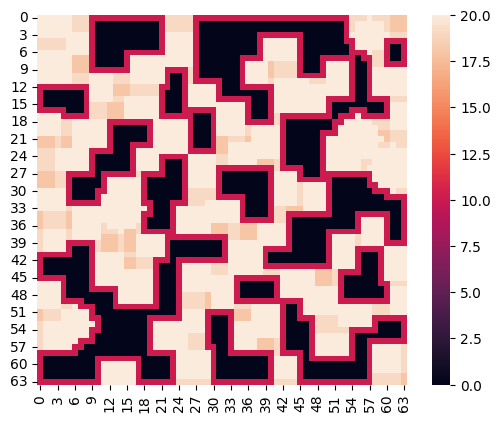

In [36]:
edge_newmatrix = find_edges_and_change(newmatrix)
sns.heatmap(edge_newmatrix, square=True, vmin=0, vmax=range_max)

<Axes: >

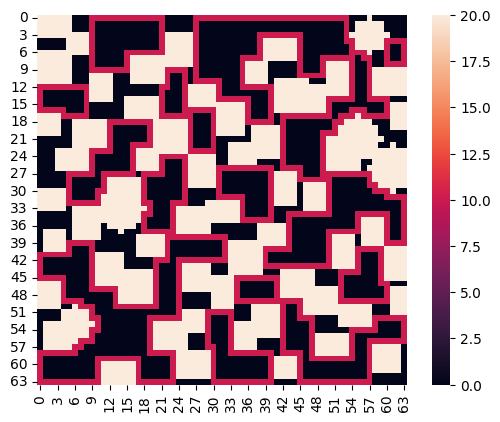

In [37]:
N = len(edge_newmatrix)
for i in range(N):
    for j in range(N):
        if edge_newmatrix[i, j] > 10 and not edge_newmatrix[i, j] == range_max:
            edge_newmatrix[i, j] = 0
sns.heatmap(edge_newmatrix, square=True, vmin=0, vmax=range_max)

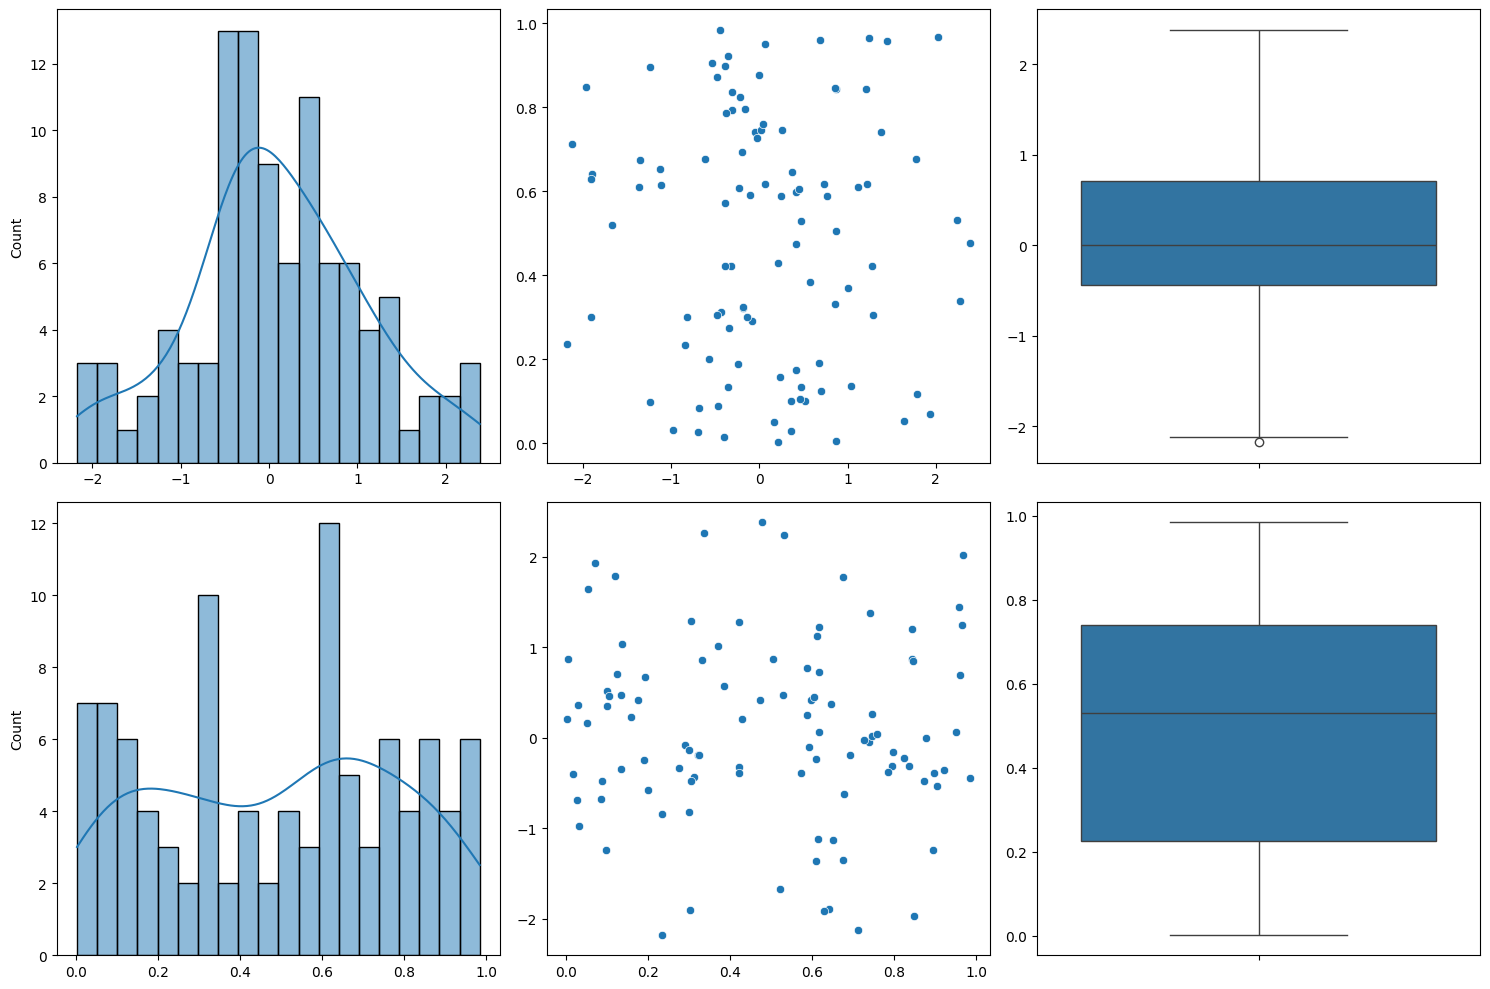

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 创建模拟数据
data1 = np.random.randn(100)
data2 = np.random.rand(100)

# 创建一个2x3的子图布局
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 第一行的绘图
sns.histplot(data1, bins=20, kde=True, ax=axes[0, 0])
sns.scatterplot(x=data1, y=data2, ax=axes[0, 1])
sns.boxplot(data=data1, ax=axes[0, 2])

# 第二行的绘图
sns.histplot(data2, bins=20, kde=True, ax=axes[1, 0])
sns.scatterplot(x=data2, y=data1, ax=axes[1, 1])
sns.boxplot(data=data2, ax=axes[1, 2])

# 调整布局以避免子图标题重叠
plt.tight_layout()

# 显示图表
plt.show()
